# Fertig's version of Variational Inference using normalizing flows

In [1]:
import scipy
import numpy as np
import pandas as pd
from tqdm import trange
import time

#import tensorflow.compat.v2 as tf
#tf.enable_v2_behavior()
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

# data splitting and outlier removal
import  sklearn.preprocessing  # StandardScaler
from sklearn.ensemble import IsolationForest
import sklearn.model_selection #  train_test_split
import colossus
from colossus.cosmology import cosmology
# Set tensor numeric type.
dtype = 'float32'

# Data Viz. 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools # to cycle through palette colors
if 1== 1 :
  sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
  )
sns.set_palette(palette='deep')
#sns.set_palette(palette="Paired_r")
#sns_c = sns.color_palette(palette="Paired_r")
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Get TensorFlow version.
print(f'TensorFlow version: {tf.__version__}')
print(f'TensorFlow Probability version: {tfp.__version__}')

if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))


2021-10-25 21:48:39.700115: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/cray/job/2.2.4-7.0.1.1_3.54__g36b56f4.ari/lib64:/opt/intel/compilers_and_libraries_2019.3.199/linux/compiler/lib/intel64:/opt/intel/compilers_and_libraries_2019.3.199/linux/mkl/lib/intel64:/usr/common/software/darshan/3.2.1/lib
2021-10-25 21:48:39.700135: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TensorFlow version: 2.8.0-dev20211012
TensorFlow Probability version: 0.15.0-dev20211013


2021-10-25 21:48:53.593597: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-25 21:48:53.605328: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-10-25 21:48:53.605348: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nid00573): /proc/driver/nvidia/version does not exist


In [11]:
# for wide spread use
# ppd_df is the output of make_posterior_predictive_distribution
def yp_on_yt_plot (y_predictions, y_sigma, y_test, ppd_df) :
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), constrained_layout=True)

    ax[0].errorbar( x=np.array(y_test), y=y_predictions, yerr=y_sigma,fmt='o',
        ecolor="r", mfc="r", mec="k", capsize=2, label='predictions + credible intervals')
    sns.regplot(x=np.array(y_test), y=y_predictions,
        scatter=False, line_kws=dict(alpha=0.5), fit_reg=True, label="linear regression", 
        truncate=False, ax=ax[0])
    ax[0].plot(ppd_df["range"],ppd_df["mean"], color="black", label="y=x, 90% posterior predictive")
    ax[0].fill_between(ppd_df["range"], ppd_df["90l"], ppd_df["90u"], color='k', alpha=.1)
    ax[0].set(title='Model Predictions for Test Sample', xlabel='y',ylabel='y_pred');
    ax[0].legend(loc='lower right')
         
    ax[1].errorbar( x=np.array(y_test), y=y_predictions-np.array(y_test), yerr=y_sigma,fmt='o', 
        #ecolor=sns_c[1], mfc=sns_c[4],
        ecolor="r", mfc="r", mec="k", capsize=2, label='predictions + credible intervals',)
    sns.regplot(x=np.array(y_test), y = y_predictions-np.array(y_test),
        scatter=False, line_kws=dict(alpha=0.5),  fit_reg=True, label="linear regression",  
        truncate=False,  ax=ax[1])
    ax[1].plot(ppd_df["range"],np.zeros(ppd_df["mean"].size), 
               color="black", label="y=x, 90% posterior predictive")
    ax[1].fill_between(ppd_df["range"], ppd_df["90l"]-ppd_df["mean"], ppd_df["90u"]-ppd_df["mean"], color='k', alpha=.1)
    ax[1].set(title='Delta Model Predictions for Test Sample', xlabel='y', ylabel='y_pred');
    ax[1].legend(loc='lower right')
    
def make_posterior_predictive_distribution (sigma, verbose=False) :
    # prepare the fit and confidence interval: weirdly, assuming that the only thing that matters is sigma
    # becuse it is a posterior predictive distribution 
    range_x = np.arange(14.0,15.0,0.05) ; 
    if verbose : print("range_x: ", range_x.shape)
    range_y = tf.map_fn(
        fn=lambda z: tfd.Normal(loc=z, scale=sigma).sample(20000), 
        elems=tf.constant(range_x , dtype=dtype )  )
    range_y = tf.squeeze(range_y)
    if verbose: print("range_y  ", range_y.shape)

    range_mean = tf.math.reduce_mean(range_y, axis=1).numpy()
    range_std = tf.math.reduce_std(range_y, axis=1).numpy()
    range_90l = range_mean - 2*range_std
    range_90u = range_mean + 2*range_std
    df = pd.DataFrame({"mean": range_mean})
    df["range"]= range_x
    df["std"]= range_std
    df["90l"]= range_90l
    df["90u"]= range_90u
    return df
#

In [2]:
cluster_data=pd.read_csv("~/Data/cluster_data_0.3-0.6-msm.csv")
clusters = pd.DataFrame( {"central_sm":cluster_data["central_sm"]} )
clusters["measured_sm"] = cluster_data["measured_sm"]
clusters["halo_mass"] = cluster_data["halo_mass"]
clusters.head()
#

,central_sm,measured_sm,halo_mass
0,12.115618,12.491581,14.658120
1,11.894872,12.111751,14.089678
2,11.763473,12.208368,14.383239
3,11.820660,12.358756,14.287383
4,11.628624,12.131789,14.141557


In [37]:
train,test = sklearn.model_selection.train_test_split(clusters, train_size=0.80)
X = train[train.columns[:-1]].astype(dtype)
y = train[train.columns[-1]].astype(dtype)
print("X, y:", X.shape, y.shape)
X_test = test[test.columns[:-1]].astype(dtype)
y_test = test[test.columns[-1]].astype(dtype)
all_X = clusters[clusters.columns[:-1]].astype(dtype)
all_y = clusters[clusters.columns[-1]].astype(dtype)

train = tf.data.Dataset.from_tensor_slices( (X, y)).shuffle(10000).batch(1000)

# Are these globals?
x = X
y = y

X, y: (229, 2) (229,)


In [55]:
#x = np.vstack([cluster_data[xname],cluster_data[x2name]]).transpose()
x = tf.convert_to_tensor(X, dtype=dtype)

y = tf.convert_to_tensor(y, dtype=dtype)
y = tf.reshape(y, (-1, 1))

print("x shape: {}, y shape: {}".format(x.shape,y.shape))
#dir(train)
#train.get_single_element()
#dir(train.batch(10))
#for i in train.batch(10).as_numpy_iterator():
#print(i)
#rtain.batch(2).get_single_element()

x shape: (229, 2), y shape: (229, 1)


## Define the physical model

In [5]:
jds_ab = tfd.JointDistributionNamedAutoBatched(dict(

    sigma=tfd.HalfNormal(scale=[tf.cast(1.0, dtype)]),

    alpha=tfd.Normal(
        #loc=[tf.cast(0.0, dtype)], 
        loc=[tf.cast(2.5, dtype)], 
        scale=[tf.cast(10.0, dtype)]
    ),

    beta=tfd.Normal(
        #loc=[[tf.cast(0.0, dtype)], [tf.cast(0.0, dtype)]], 
        loc=[[tf.cast(0.5, dtype)], [tf.cast(0.35, dtype)]],
        scale=[[tf.cast(10.0, dtype)], [tf.cast(10.0, dtype)]]
    ),

    y=lambda beta, alpha, sigma: 
        tfd.Normal(
            loc=tf.linalg.matmul(x, beta) + alpha, 
            scale=sigma
        ) 
))

In [7]:
#tf.keras.backend.clear_session()
# Define the probabilistic graphical model as a JointDistribution.
def out_y_point (alpha, beta, x) :
    beta = tf.reshape(beta,[2,-1])
    return tf.linalg.matmul(x, beta) + alpha
def out_y (alpha, beta, sigma, x) :
    return tfd.Normal( loc=out_y_point(alpha, beta, x), scale=sigma, name="y")

@tfd.JointDistributionCoroutineAutoBatched
def model_standard():
    alpha = yield  tfd.Normal( loc=5.0, scale=3, name="alpha")
    beta =  yield tfd.Normal( loc=[0.5,0.5], scale=[3.0,3.0], name="beta")
    sigma = yield tfd.HalfNormal(scale=0.5, name="sigma")                                   
    y = yield  out_y(alpha, beta, sigma, x)
    
@tfd.JointDistributionCoroutineAutoBatched
def model_yyz():
    alpha = yield  tfd.Normal( loc=3.0, scale=6.0, name="alpha")
    beta =  yield tfd.Normal( loc=[0.0,0.0], scale=[3.0,3.0], name="beta")
    sigma = yield tfd.HalfNormal(scale=1.0, name="sigma")
    q = yield tfd.Normal ( loc=0.0, scale=1.0, name="q")                                   
    y = yield  out_y(alpha, beta, (sigma + q* (out_y_point(alpha, beta, x)-12.0)), x)
    
@tfd.JointDistributionCoroutineAutoBatched
def model_vector():
    alpha = yield  tfd.Normal( loc=3.0, scale=6.0, name="alpha")
    beta =  yield tfd.Normal( loc=[0.0,0.0], scale=[3.0,3.0], name="beta")
    sigma = yield tfd.HalfNormal(
                loc=(out_y_point(alpha,beta,x)-12.0), 
                scale=tf.math.softplus( 0.005*(out_y_point(alpha,beta,x)-12.0)) + 0.001, 
                name="sigma")                                
    y = yield  out_y(alpha, beta, sigma, x)
    
def pack_samples(samples):
  try :
    dict= {'alpha': samples.alpha,
          'beta0': samples.beta[...,0],
          'beta1': samples.beta[...,1],
          'sigma': samples.sigma,
          }
  except :
    dict= {'alpha': samples["alpha"],
          'beta0': samples["beta0"],
          'beta1': samples["beta1"],
          'sigma': samples["sigma"],
          }
  return dict

params = ["beta0", "beta1", "alpha", "sigma"];# wonder how to get this automatically
    
model = model_standard
target_model = model

print("model.event_shape: \n",model.event_shape)
print( target_model.event_shape_tensor())

model.event_shape: 
 StructTuple(
  alpha=TensorShape([]),
  beta=TensorShape([2]),
  sigma=TensorShape([]),
  y=TensorShape([229, 1])
)
StructTuple(
  alpha=<tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>,
  beta=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>,
  sigma=<tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>,
  y=<tf.Tensor: shape=(2,), dtype=int32, numpy=array([229,   1], dtype=int32)>
)


In [ ]:
# Sample from the prior.
prior_samples = jds_ab.sample(500)['y']

prior_samples = tf.squeeze(prior_samples)
prior_mean = tf.math.reduce_mean(prior_samples, axis=0).numpy()
prior_std = tf.math.reduce_std(prior_samples, axis=0).numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 6), constrained_layout=True)
sns.regplot(
    x=tf.squeeze(y).numpy(), 
    y=prior_mean, 
    #scatter=False,
    line_kws=dict(alpha=0.5), 
    label='y ~ y_pred', 
    truncate=False,
    ax=ax
)
#print(tf.squeeze(y).numpy())
#print(prior_mean)
      
#ax.axline(xy1=(0,0), slope=1, linestyle='--', color=sns_c[3], label='diagonal (y = y_pred)')
ax.legend(loc='lower right')
ax.set(title='Model Prior Predictions', xlabel='y', ylabel='y_pred');

## Variational Inference
### Change the form of the posterior surrogate to Inverse Autoregressive Flow surrogate posterior


In [8]:
# target_model is set when one sets the model earlier in the noebook.


# Determine the `event_shape` of the posterior, and calculate the size of each
# `event_shape` component. These determine the sizes of the components of the
# underlying standard Normal distribution, and the dimensions of the blocks in
# the blockwise matrix transformation.
event_shape = target_model.event_shape_tensor()
flat_event_shape = tf.nest.flatten(event_shape)
flat_event_size = tf.nest.map_structure(tf.reduce_prod, flat_event_shape)

print("event_shape:  ", event_shape)
print("\n\nflat_event_shape:")
for fes in flat_event_shape:
  print(fes)
print("\n\nflat_event_size:")
for fes in flat_event_size:
  print(fes)

# The `event_space_bijector` maps unconstrained values (in R^n) to the support
# of the prior -- we'll need this at the end to constrain Multivariate Normal
# samples to the prior's support.
event_space_bijector = target_model.experimental_default_event_space_bijector()

base_standard_dist = tfd.JointDistributionSequential(
      [tfd.Sample(tfd.Normal(0., 1.), s) for s in flat_event_size])

#block_tril_linop = (
#    tfp.experimental.vi.util.build_trainable_linear_operator_block(
#        operators, flat_event_size))
#scale_bijector = tfb.ScaleMatvecLinearOperatorBlock(block_tril_linop)

loc_bijector = tfb.JointMap(
    tf.nest.map_structure(
        lambda s: tfb.Shift(
            tf.Variable(tf.random.uniform(
                (s,), minval=-2., maxval=2., dtype=tf.float32))),
        flat_event_size))


reshape_bijector = tfb.JointMap(
   tf.nest.map_structure(tfb.Reshape, flat_event_shape))
unflatten_bijector = tfb.Restructure(
       tf.nest.pack_sequence_as(
           event_shape, range(len(flat_event_shape))))

# event_space_bijector = target_model.experimental_default_event_space_bijector()

# Reshape each component to match the prior, using a nested structure of
# `Reshape` bijectors wrapped in `JointMap` to form a multipart bijector.
reshape_bijector = tfb.JointMap(
    tf.nest.map_structure(tfb.Reshape, flat_event_shape))

# Restructure the flat list of components to match the prior's structure
unflatten_bijector = tfb.Restructure(
        tf.nest.pack_sequence_as(
            event_shape, range(len(flat_event_shape))))


event_shape:   StructTuple(
  alpha=<tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>,
  beta=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>,
  sigma=<tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>,
  y=<tf.Tensor: shape=(2,), dtype=int32, numpy=array([229,   1], dtype=int32)>
)


flat_event_shape:
tf.Tensor([], shape=(0,), dtype=int32)
tf.Tensor([2], shape=(1,), dtype=int32)
tf.Tensor([], shape=(0,), dtype=int32)
tf.Tensor([229   1], shape=(2,), dtype=int32)


flat_event_size:
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(229, shape=(), dtype=int32)


In [9]:
# Build a standard Normal with a vector `event_shape`, with length equal to the
# total number of degrees of freedom in the posterior.
base_distribution = tfd.Sample(
    tfd.Normal(0., 1.), sample_shape=[tf.reduce_sum(flat_event_size)])

# Apply an IAF to the base distribution.
num_iafs = 2
iaf_bijectors = [
    tfb.Invert(tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
            params=2, hidden_units=[256, 256], activation='relu')))
    for _ in range(num_iafs)
]

# Split the base distribution's `event_shape` into components that are equal
# in size to the prior's components.
split = tfb.Split(flat_event_size)

# Chain these bijectors and apply them to the standard Normal base distribution
# to build the surrogate posterior. `event_space_bijector`,
# `unflatten_bijector`, and `reshape_bijector` are the same as in the
# multivariate Normal surrogate posterior.
iaf_surrogate_posterior = tfd.TransformedDistribution(
    base_distribution,
    bijector=tfb.Chain([
         event_space_bijector,  # constrain the surrogate to the support of the prior
         unflatten_bijector,  # pack the reshaped components into the `event_shape` structure of the prior
         reshape_bijector,  # reshape the vector-valued components to match the shapes of the prior components
         split] +  # Split the samples into components of the same size as the prior components
         iaf_bijectors  # Apply a flow model to the Tensor-valued standard Normal distribution
         ))



2021-10-25 21:54:13.826009: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x55555b89e360 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-10-25 21:54:13.826030: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Host, Default Version
2021-10-25 21:54:13.942482: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:102] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. fit_surrogate_posterior/sanitize_seed/seed
2021-10-25 21:54:13.946283: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:237] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2021-10-25 21:54:21.643642: I tensorflow/compiler/jit/xla_compilation_cache.cc:351] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


optimizing time: 364.940048 seconds
IAF surrogate posterior ELBO: -8.60875415802002


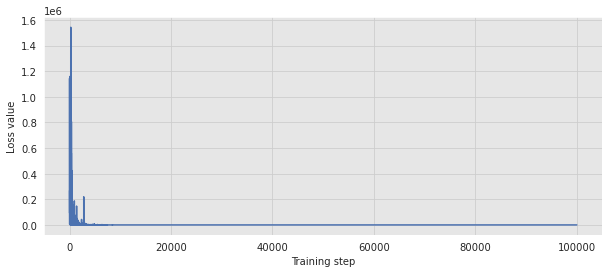

In [10]:
start = time.time()
optimizer=tf.optimizers.Adam(learning_rate=1e-3)
iaf_loss = tfp.vi.fit_surrogate_posterior(
  target_model.unnormalized_log_prob,
  iaf_surrogate_posterior,
  optimizer=optimizer,
  #num_steps=10**4,
  num_steps=10**5,
  sample_size=4,
  jit_compile=True)
end = time.time()
print("optimizing time: {:2f} seconds".format(end - start))

iaf_samples = iaf_surrogate_posterior.sample(1000)
iaf_final_elbo = tf.reduce_mean(
    target_model.unnormalized_log_prob(*iaf_samples)
    - iaf_surrogate_posterior.log_prob(iaf_samples))
print('IAF surrogate posterior ELBO: {}'.format(iaf_final_elbo))

plt.figure(figsize=(10, 4))
plt.plot(iaf_loss)
plt.xlabel('Training step')
_ = plt.ylabel('Loss value')




4.5335145

 Test data

   posterior_std  chi-sq and rms: 271.00 14.525


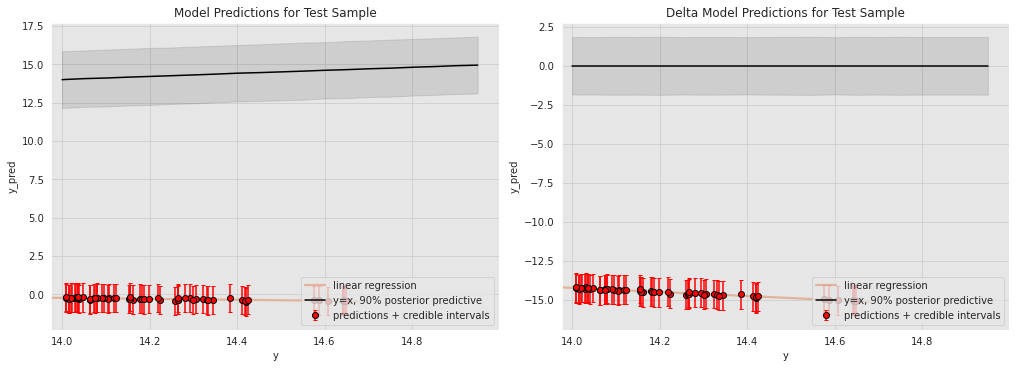

In [21]:
def get_y_predictions(alpha, beta, sigma, x) :
    beta = tf.reshape(beta,[2,-1])
    return tfd.Normal( loc=tf.linalg.matmul(x, beta) + alpha, scale=sigma)

iaf_samples = iaf_surrogate_posterior.sample(10000)
#print(iaf_samples[0].numpy().mean())
alpha = iaf_samples[0].numpy()
beta = iaf_samples[1].numpy()
sigma = iaf_samples[2].numpy()

y_model = get_y_predictions(alpha, beta, sigma, tf.convert_to_tensor(X_test, dtype=dtype))
posterior_mean =( y_model.mean()).numpy().mean(axis=1)
posterior_std = ( y_model.stddev()).numpy().mean(axis=1)

chisq = (((posterior_mean-y_test)/posterior_std)**2).sum()/(y_test.size-len(params)-1)
rms = np.sqrt(((posterior_mean-y_test)**2).sum()/y_test.size)

print("\n Test data\n")
print ("   posterior_std  chi-sq and rms: {:6.2f} {:6.3f}".format(chisq, rms))

# posterior predictive distribution 
ppd_df = make_posterior_predictive_distribution (sigma.mean())
yp_on_yt_plot (posterior_mean, posterior_std, y_test, ppd_df)